In [1]:
Z_DIM = 10

### 1. Load Colored MNIST dataset

In [ ]:
import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.utils as vutils

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time

import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output

!pip install -q torchsummary
from torchsummary import summary

!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete
pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

from matplotlib.gridspec import GridSpec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 3.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
colors = [
        'darkgreen', '#6495ed', 'darkblue', '#b03060',
        'orangered', 'yellow', 'burlywood', 'lime',
        'aqua', 'fuchsia',
    ]
color_names = ['darkgreen', 'blue', 'darkblue', 'maroon', 'orangered',
            'yellow', 'burlywood', 'lime', 'aqua', 'fuchsia']
color_dict = {k: v for k, v in enumerate(color_names)}

def get_rgb(x):
    t = torch.tensor(ImageColor.getcolor(x, "RGB")) / 255.
    return t.view(-1, 1, 1)

NUM_COLORS = len(colors)
colors = list(map(get_rgb, colors))
COUNTERFACTUAL_LABELS = [0,2,4,6,8]

class DoubleColoredMNIST(Dataset):
    def __init__(self, train=True, counterfactual=False):
        self.train = train
        self.counterfactual = counterfactual
        self.mnist_sz = 28

        # get mnist
        if train:
            mnist = datasets.MNIST(root='data', download=True, train=True)
        else:
            mnist = datasets.MNIST(root='data', download=True, train=False)
        ims, labels = mnist.data, mnist.targets
        # self.T = transforms.Compose([
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        # ])
        if self.counterfactual:
            self.ims_digit = []
            self.labels = []
            for im, l in zip(torch.stack([ims, ims, ims], dim=1), labels):
                if l.item() in COUNTERFACTUAL_LABELS:
                    self.ims_digit.append(im)
                    self.labels.append(l)
            self.labels = np.array(self.labels)
        else:
            self.ims_digit = torch.stack([ims, ims, ims], dim=1)
            self.labels = labels

    def __getitem__(self, idx):
        digit = self.labels[idx]
        if self.train:
            if digit.item() in COUNTERFACTUAL_LABELS:
                fg_i = np.random.choice([i for i in range(NUM_COLORS) if i != digit])
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i not in [digit, (digit + 1) % NUM_COLORS, fg_i]])
            else:
                fg_i = np.random.choice(NUM_COLORS)
                bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        elif self.counterfactual:
            fg_i = int(digit)
            bg_i = int((digit + 1) % NUM_COLORS)
        else:
            fg_i = np.random.choice(NUM_COLORS)
            bg_i = np.random.choice([i for i in range(NUM_COLORS) if i != fg_i])
        back_color = colors[bg_i].clone()
        back_color += torch.normal(0, 1e-3, (3, 1, 1))
        obj_color = colors[fg_i].clone()
        obj_color += torch.normal(0, 1e-3, (3, 1, 1))

        # get digit
        im_digit = (self.ims_digit[idx] / 255.).to(torch.float32)
        im_digit = F.interpolate(im_digit[None,:], (self.mnist_sz, self.mnist_sz)).squeeze()
        im_digit = (im_digit > 0.1).to(int)  # binarize

        # plot digit onto the texture
        ims = im_digit * (obj_color) + (1 - im_digit) * back_color

        ret = {
            # 'img': self.T(ims),
            'img': ims,
            'label': np.array([digit, fg_i, bg_i], dtype=int),
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [ ]:
LABEL_SIZES = [10, NUM_COLORS, NUM_COLORS]
LABEL_NAMES = ['digit', 'obj_color', 'bg_color']
dataset_train = DoubleColoredMNIST(train=True)
dataset_test = DoubleColoredMNIST(train=False)
dataset_counterfactual = DoubleColoredMNIST(train=False, counterfactual=True)
print(len(dataset_train), len(dataset_test), len(dataset_counterfactual))

In [ ]:
def normalize(img):
    # a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img #* a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [dataset_train, dataset_test, dataset_counterfactual]):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label']))
        plt.axis('off')
    plt.suptitle(n, y=.9)
    plt.show()

In [ ]:
BATCH_SIZE = 256
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)
cf_loader = DataLoader(dataset_counterfactual, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

### 2. CVAEGAN

In [ ]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)

def get_one_hot(labels):
    new_ys = []
    for i, label_length in enumerate(LABEL_SIZES):
        new_y = nn.functional.one_hot(labels[:, i].to(torch.int64), int(label_length))
        new_ys.append(new_y)
    new_ys = torch.cat(new_ys, -1)
    return new_ys.to(torch.float32)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.1):
        super(Decoder, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Linear(z_dim+label_dim, 64*7*7),
            Reshape((-1, 64, 7, 7)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((14, 14)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((28, 28)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, z, labels):
        data = torch.cat([z, get_one_hot(labels)], dim=1)
        prob_output = self.layers(data)
        return prob_output

class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.1):
        super(Encoder, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Conv2d(3+label_dim, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(3136, z_dim)
        self.fc_output_scale = nn.Linear(3136, z_dim)

    def forward(self, x, labels):
        labels = get_one_hot(labels).T
        labels = labels.expand([28, 28, self.label_dim, labels.size(1)]).T
        data = torch.cat([x, labels], dim=1)  # (BS, 33, 28, 28)
        hidden = self.layers(data)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

class Discriminator(nn.Module):
    def __init__(self, label_dim=30, p=0.3):
        super(Discriminator, self).__init__()
        self.label_dim = label_dim
        self.layers = nn.Sequential(
            nn.Conv2d(3+label_dim, 128, 5, 2, 1),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p),
            nn.Linear(2304, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        labels = get_one_hot(labels).T
        labels = labels.expand([28, 28, self.label_dim, labels.size(1)]).T
        data = torch.cat([x, labels], dim=1)  # (BS, 33, 28, 28)
        return self.layers(data)

In [ ]:
class CVAE_GAN(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=30, p=0.2, use_cuda=False):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim, label_dim=label_dim, p=p)
        self.discriminator_ = Discriminator(label_dim, p=p)
        if use_cuda:
            self.cuda()
        self.device = 'cuda' if use_cuda else 'cpu'
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    def model(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        self.discriminator_.train(False)
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(z, labels)
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3), obs=x.squeeze())

            # is_real part
            prob_real = self.discriminator_(loc_img, labels).squeeze()
            prob_real = prob_real.expand([28*28*3, *prob_real.shape]).T
            ones = torch.full((x.shape[0],), 1., dtype=torch.float, device=self.device)
            ones = ones.expand([28*28*3, *ones.shape]).T
            pyro.sample("is_real", dist.Bernoulli(prob_real).to_event(1), obs=ones)

    def guide(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, labels)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def model_generate(self, batch_size):
        self.discriminator_.train(False)
        pyro.module("decoder", self.decoder_)
        with pyro.plate("data", batch_size):
            # pior for Z
            z_loc = torch.zeros(torch.Size((batch_size, self.z_dim)), dtype=torch.float, device=self.device)
            z_scale = torch.ones(torch.Size((batch_size, self.z_dim)), dtype=torch.float, device=self.device)
            z = dist.Normal(z_loc, z_scale).rsample()

            # random labels for generation
            rand_labels = torch.randint(low=0, high=10, size=(batch_size, 3), device=self.device)
            loc_img = self.decoder_(z, rand_labels)
            prob_real = self.discriminator_(loc_img, rand_labels).squeeze()
            ones = torch.full((batch_size,), 1., dtype=torch.float, device=self.device)
            pyro.sample("obs", dist.Bernoulli(prob_real), obs=ones)

    def guide_generate(self, batch_size):
        pass

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        loc_img = self.decoder_(z, labels)
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    def reconstruct_img(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder_(z, labels)
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()
real_label = 1.
fake_label = 0.

### 3. Inference (711 epochs, small)

In [ ]:
pyro.clear_param_store()
vae = CVAE_GAN(p=0.2, use_cuda=USE_CUDA)
vae.load_state_dict(torch.load('/content/vaegan_zdim10_epoch711.pt', map_location='cpu'))

<All keys matched successfully>

In [ ]:
all_combinations = []
for digit in range(10):
    for fg_color in range(10):
        for bg_color in range(10):
            all_combinations.append([digit, fg_color, bg_color])
all_combinations = torch.tensor(all_combinations)  # (1000, 3)
label_loader = DataLoader(all_combinations, batch_size=256, shuffle=False, num_workers=2, drop_last=False)

results = []
for fixed_labels in label_loader:
    fixed_noise = torch.randn(len(fixed_labels), Z_DIM, device=device)
    with torch.no_grad():
        fake = vae.decoder(fixed_noise, fixed_labels).detach().cpu()
    results.append(fake)
results = torch.concatenate(results)

In [ ]:
# counterfactual hunt
gen_001, gen_223, gen_445, gen_667, gen_889 = [], [], [], [], []
while len(gen_001) < 16 or len(gen_223) < 16 or len(gen_667) < 16 or len(gen_889) < 16 or len(gen_445) < 16:
    fixed_noise = torch.randn(256, Z_DIM, device=device)
    fixed_labels = torch.randint(low=0, high=10, size=(256, 3), device=device)
    with torch.no_grad():
        fake = vae.decoder(fixed_noise, fixed_labels).detach().cpu()
    ids = ((fixed_labels == torch.tensor([0,0,1])).sum(1) == 3).nonzero(as_tuple=True)[0]
    gen_001.extend(fake[ids])
    ids = ((fixed_labels == torch.tensor([2,2,3])).sum(1) == 3).nonzero(as_tuple=True)[0]
    gen_223.extend(fake[ids])
    ids = ((fixed_labels == torch.tensor([4,4,5])).sum(1) == 3).nonzero(as_tuple=True)[0]
    gen_445.extend(fake[ids])
    ids = ((fixed_labels == torch.tensor([6,6,7])).sum(1) == 3).nonzero(as_tuple=True)[0]
    gen_667.extend(fake[ids])
    ids = ((fixed_labels == torch.tensor([8,8,9])).sum(1) == 3).nonzero(as_tuple=True)[0]
    gen_889.extend(fake[ids])
    print(len(gen_001), len(gen_223), len(gen_667), len(gen_889), len(gen_445))

0 0 0 1 0
0 0 0 1 0
0 0 1 1 1
0 2 1 1 2
0 2 1 1 2
0 2 1 1 2
0 2 3 2 2
0 2 3 2 2
1 2 4 2 2
1 3 4 3 2
1 4 4 3 2
1 4 4 3 3
1 4 4 3 3
3 4 4 5 3
3 5 4 5 3
3 5 5 6 3
3 5 5 6 4
3 5 5 6 4
3 5 5 6 4
3 5 5 6 4
4 5 5 6 4
4 5 5 6 5
4 5 5 7 5
4 5 5 7 5
4 5 5 7 6
4 5 5 7 6
5 5 5 8 6
5 5 5 8 6
5 5 5 8 7
5 5 5 9 7
5 5 5 9 8
5 7 5 9 8
5 7 5 9 9
5 8 5 9 10
5 8 5 9 10
5 8 5 9 11
6 8 5 9 11
6 8 5 10 11
6 8 5 10 13
7 9 6 10 13
8 9 6 10 13
8 9 6 10 13
9 9 6 11 13
9 9 6 12 13
10 9 6 12 13
10 9 6 13 13
10 9 6 13 13
10 9 6 13 13
11 9 6 14 13
11 10 6 14 13
11 10 6 15 13
11 10 6 16 13
11 10 7 16 14
11 11 9 16 14
11 11 9 16 15
11 11 9 16 15
12 11 9 18 15
12 11 9 20 15
13 11 9 20 15
13 11 9 21 15
13 11 9 21 15
13 12 10 21 15
13 12 10 21 16
13 12 10 21 17
13 12 10 21 17
13 13 10 22 17
13 13 11 22 17
13 13 11 23 17
13 14 12 23 17
13 14 12 23 17
14 14 12 23 17
14 15 12 23 17
15 15 12 23 17
15 15 12 24 18
15 16 13 24 18
16 16 13 24 18
16 17 13 24 18
16 17 13 24 18
16 17 13 24 18
16 19 13 26 18
16 19 14 27 19
18 19 14 

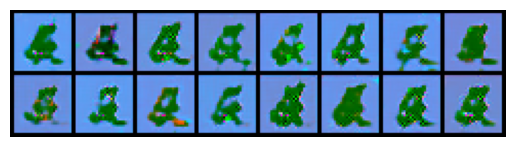

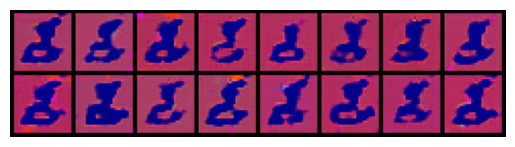

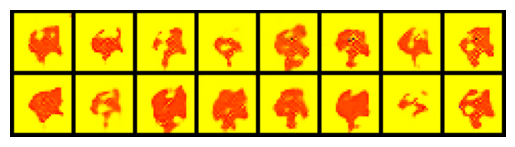

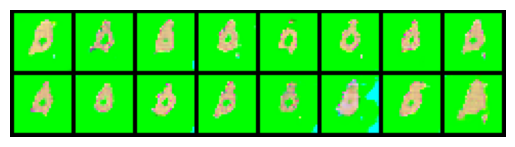

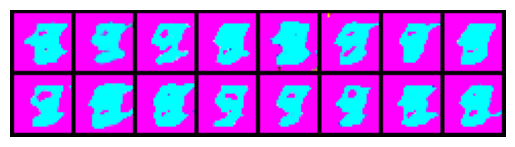

In [ ]:
for gen in [gen_001, gen_223, gen_445, gen_667, gen_889]:
    gen_img = vutils.make_grid(gen[:16], nrow=8, padding=2, normalize=True)
    plt.axis("off")
    plt.imshow(np.transpose(gen_img, (1,2,0)))
    plt.show()

DIGIT: 0


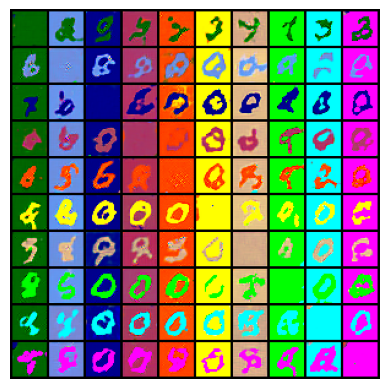

DIGIT: 1


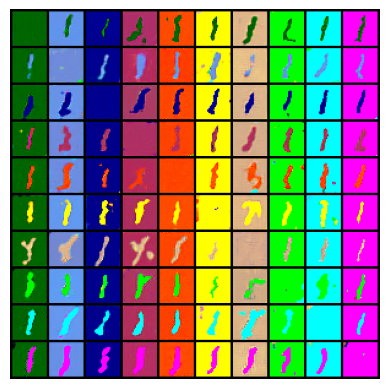

DIGIT: 2


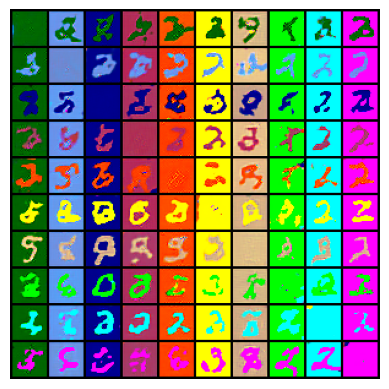

DIGIT: 3


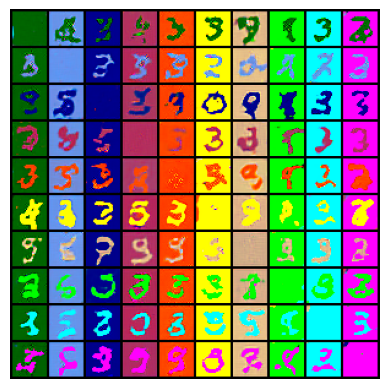

DIGIT: 4


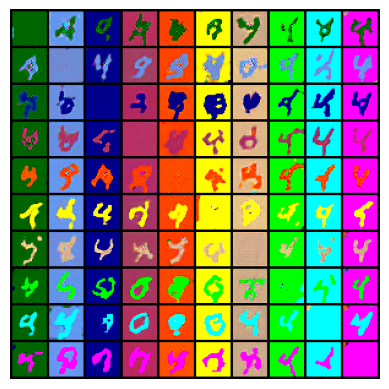

DIGIT: 5


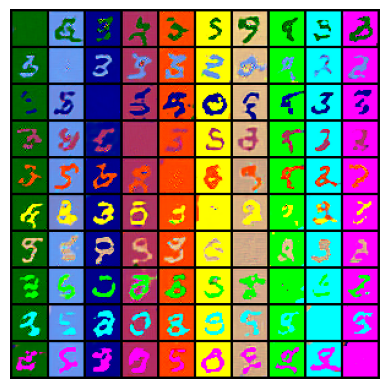

DIGIT: 6


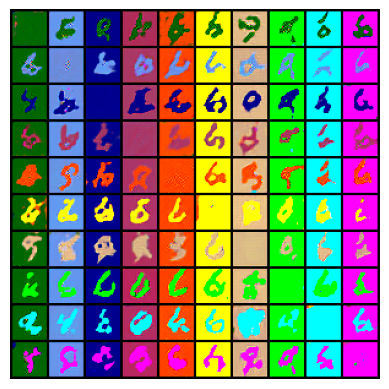

DIGIT: 7


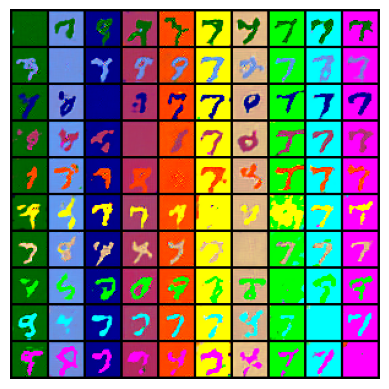

DIGIT: 8


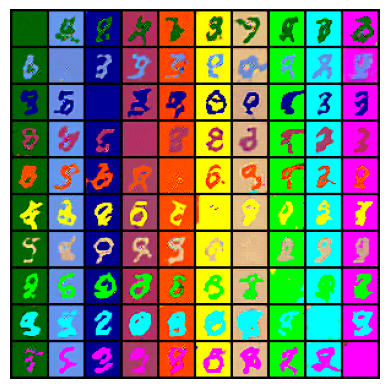

DIGIT: 9


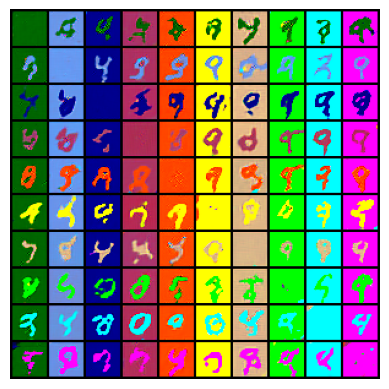

In [ ]:
for i in range(10):
    print('DIGIT:', i)
    gen_img = vutils.make_grid(results[i*100:(i+1)*100], nrow=10, padding=2, normalize=True)
    plt.axis("off")
    plt.imshow(np.transpose(gen_img, (1,2,0)))
    plt.show()